In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sc

import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Step 1: Reading &  cleansing the data

In [112]:
rentals = pd.read_csv("day.csv")

In [113]:
rentals.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [114]:
rentals.info()

# no nulls 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [115]:
# DROP the irrelevant columns
rentals.drop(["instant", "casual", "registered"], axis = 1, inplace = True)

In [116]:
#### no nulls, let s correct data types
## date to date time

rentals.dteday  =  rentals.dteday.apply(lambda x:pd.to_datetime(x))

In [117]:
# RENAME COLUMNS
rentals.rename(columns = {"dteday": "date", "mnth": "month", "cnt":"count", "hum":"humidity", "yr":"year"} , inplace = True)

In [118]:
rentals.columns

Index(['date', 'season', 'year', 'month', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'humidity', 'windspeed', 'count'],
      dtype='object')

In [119]:
print(rentals.season.value_counts())
print(rentals.weathersit.value_counts())

print(rentals.weekday.value_counts())
print(rentals.month.value_counts())

3    188
2    184
1    180
4    178
Name: season, dtype: int64
1    463
2    246
3     21
Name: weathersit, dtype: int64
0    105
1    105
6    105
2    104
4    104
5    104
3    103
Name: weekday, dtype: int64
1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: month, dtype: int64


In [120]:
## map the categorical parameters as suggested in Data dictionary
rentals.season = rentals.season.replace({1: "spring" ,2: "summer", 3: "fall" , 4: "winter" })

In [121]:
#map the weathers as per data dictionary
rentals.weathersit = rentals.weathersit.replace({1: "clear", 2: "cloudy", 3: "lightly rainy", 4: "heavily rainy" })

In [122]:
## oddly Monday is considered as 6th day of week and so on(referred to calendar to find 1st Jan 2018 was Monday) anyway..
rentals.weekday = rentals.weekday.replace({6: "mon" , 0:"tue" , 1:"wed",2:"thurs",3:"fri",4:"sat", 5:"sun" })

In [123]:

rentals.workingday = rentals.weekday.map({'mon':0, 'tue':0, 'wed':0, 'thurs':0, 'fri':0, 'sat':1, 'sun' :1})

In [124]:
#map the months as per data dictionary
rentals.month =rentals.month.replace({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun', 7:'jul', 8:'aug', 9:'sep', 10:'oct',11:'nov', 12:'dec'}) 

In [125]:
# have a quick look at how the data looks like
rentals.head(25)

,date,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,count
0,2018-01-01,spring,0,jan,0,mon,0,cloudy,14.110847,18.181250,80.5833,10.749882,985
1,2018-02-01,spring,0,jan,0,tue,0,cloudy,14.902598,17.686950,69.6087,16.652113,801
2,2018-03-01,spring,0,jan,0,wed,0,clear,8.050924,9.470250,43.7273,16.636703,1349
3,2018-04-01,spring,0,jan,0,thurs,0,clear,8.200000,10.606100,59.0435,10.739832,1562
4,2018-05-01,spring,0,jan,0,fri,0,clear,9.305237,11.463500,43.6957,12.522300,1600
5,2018-06-01,spring,0,jan,0,sat,1,clear,8.378268,11.660450,51.8261,6.000868,1606
6,2018-07-01,spring,0,jan,0,sun,1,cloudy,8.057402,10.441950,49.8696,11.304642,1510
7,2018-08-01,spring,0,jan,0,mon,0,cloudy,6.765000,8.112700,53.5833,17.875868,959
8,2018-09-01,spring,0,jan,0,tue,0,clear,5.671653,5.808750,43.4167,24.250650,822
9,2018-10-01,spring,0,jan,0,wed,0,clear,6.184153,7.544400,48.2917,14.958889,1321


## Step2:  Visualising data

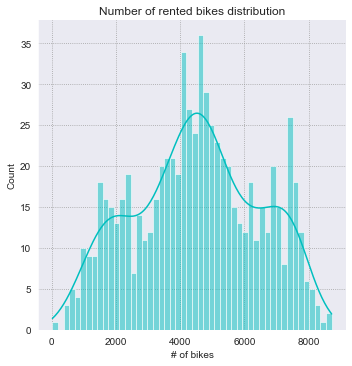

In [126]:
# distribution of rented bikes
sc.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sc.displot(data = rentals, x = "count", kde = 'true', bins = 50, color = 'c' )
plt.title('Number of rented bikes distribution')
plt.xlabel("# of bikes")
plt.show()
#INSIGHT: maximum bikes rented on a day is about 5k

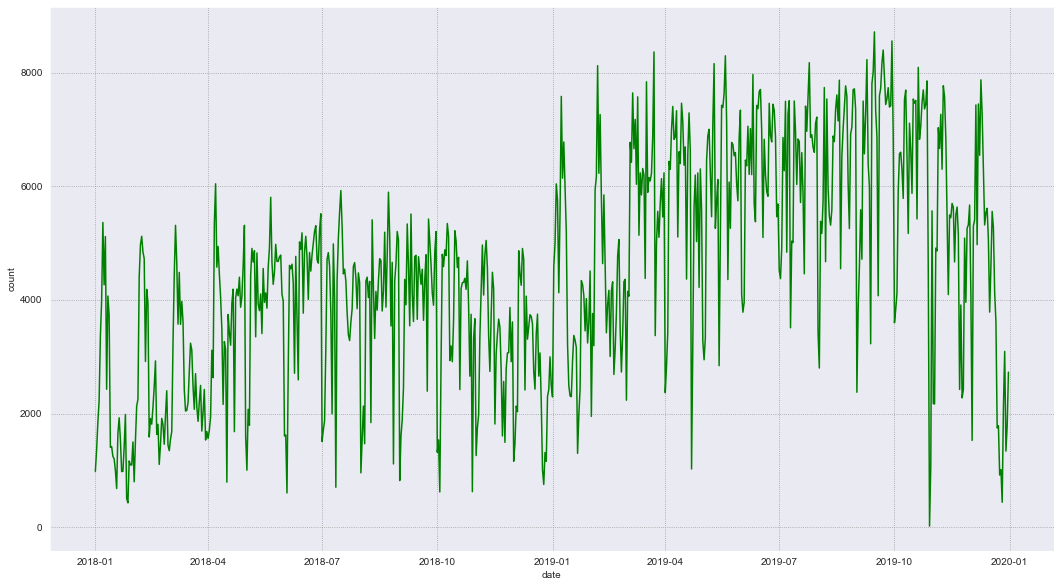

In [127]:
plt.rcParams['figure.figsize']=18,10
sc.lineplot(data = rentals, x = "date", y = "count",color = 'g')
plt.show()

#INSIGHT: Considerable rise in bike renting business in 2019. 

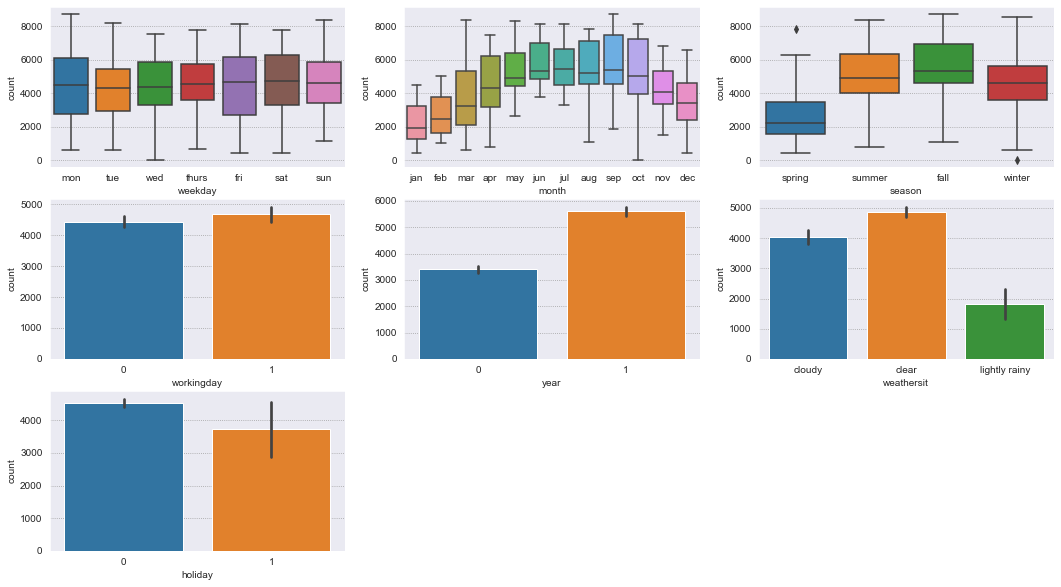

In [128]:
plt.subplot(3,3,1)
sc.boxplot(data = rentals, x = 'weekday', y = 'count')

plt.subplot(3,3,2)
sc.boxplot(data = rentals, x = 'month', y = 'count')

plt.subplot(3,3,3)
sc.boxplot(data = rentals, x = 'season', y = 'count')

plt.subplot(3,3,4)
sc.barplot(data = rentals, x = 'workingday', y = 'count',)

plt.subplot(3,3,5)
sc.barplot(data = rentals, x = 'year', y = 'count' )

plt.subplot(3,3,6)
sc.barplot(data = rentals, x = 'weathersit', y = 'count')

plt.subplot(3,3,7)
sc.barplot(data = rentals, x = 'holiday', y = 'count')

plt.show()


#INSIGHT: 
#plot1: Shows the number of bikes renting stay similar through out the week. No pattern days wise 
#plot2: The number of rented bikes show a decline in Jan, Feb, Nov, Dec
#plot 3: renting business shows remarkable relation to seasons.. increases in summer and fall and is lowest in spring followed by Winters.
#plot 4: working day: Only a slight increase in avg number of bikes rented during weekdays.  Suggests that ppl are using bikes not only for work.
#plot5: more than 50% increase in avg number of rented bikes in year 2019
#plot6: Rain have significantly negative impact on bikes renting. It is best on clear days. No data available for heavily raining weather.
#plot7: Avg. No. of rented bikes are less on holidays, may be more ppl out of town. 

In [129]:
rentals.columns

Index(['date', 'season', 'year', 'month', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'humidity', 'windspeed', 'count'],
      dtype='object')

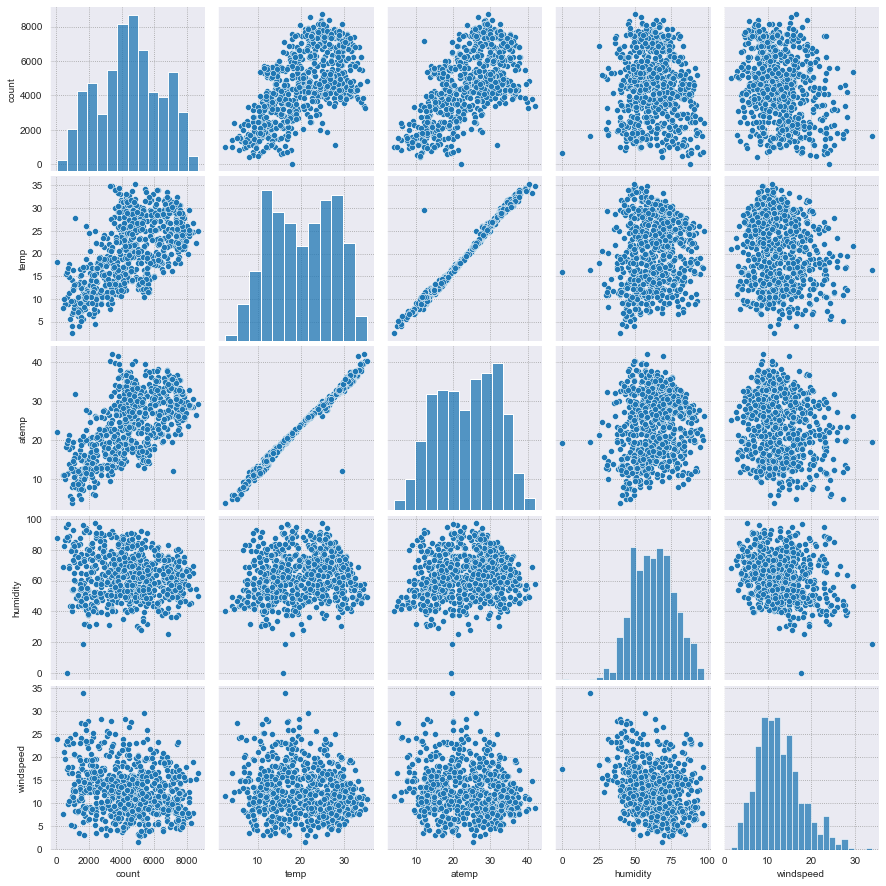

In [130]:
#plt.rcParams['figure.figsize']=20,20
sc.pairplot(rentals, x_vars= ['count', 'temp', 'atemp','humidity','windspeed'] , y_vars = ['count','temp', 'atemp','humidity','windspeed'])

#INSIGHTS: number of rented bikes increase as temprature(temp/atemp) increases
#Strong colinear relation between temp and atemp. probably one of them can be dropped.
#humidity, windspeed seem to be randomly distributed across temps and rented bikes count
# very few outliers in overall data.

<AxesSubplot:>

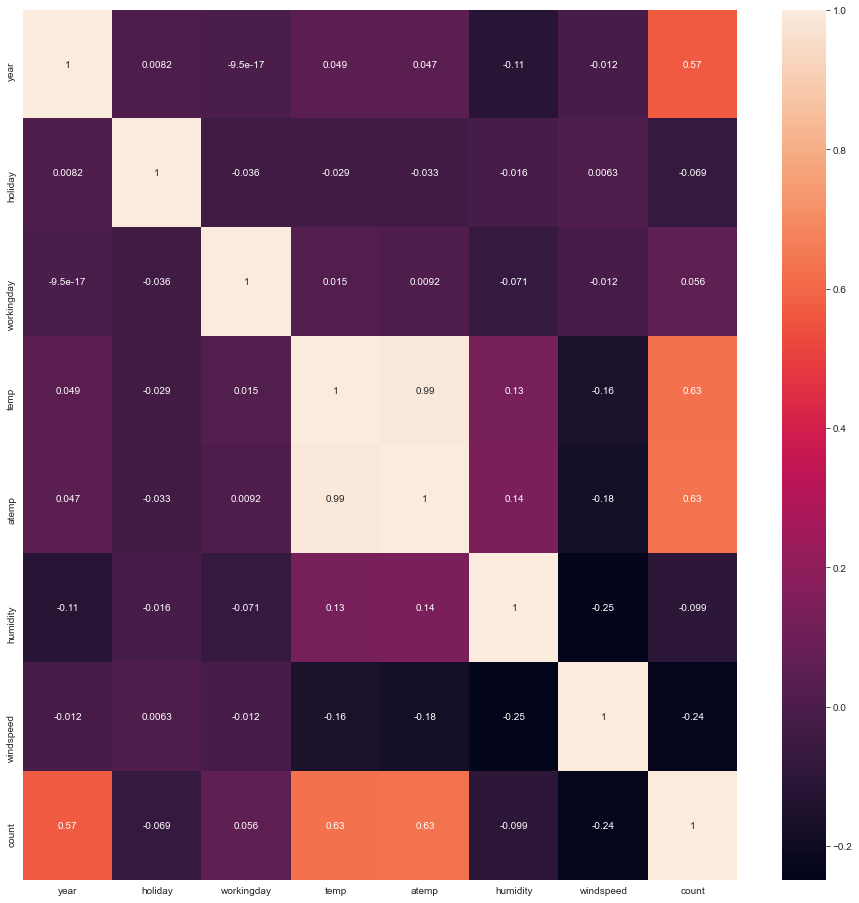

In [131]:
plt.figure(figsize = (16, 16))
sc.heatmap(rentals.corr(), annot = True)

#same observations are indicated in corelation between various variables.

## Step 3  Preparing the data for modeling

In [132]:
#convert date to numerical type for fitting
import datetime as dt
rentals["date"] = rentals['date'].map(dt.datetime.toordinal)

In [133]:
#creating dummy variables for categorical variables (season, month, weekday and weathersit)

season_d = pd.get_dummies(rentals.season, drop_first = True)

month_d = pd.get_dummies(rentals.month, drop_first = True)
weekday_d = pd.get_dummies(rentals.weekday, drop_first = True)
weathersit_d = pd.get_dummies(rentals.weathersit, drop_first = True)
rentals.drop(['season', 'month', 'weekday', 'weathersit'], axis = 1, inplace = True)
rentals = pd.concat([rentals, season_d,month_d, weekday_d,weathersit_d ], axis =1 )


In [134]:
## splitting train and test data
df_train, df_test = train_test_split(rentals, train_size = 0.7, random_state = 10)

In [135]:
df_train.columns

Index(['date', 'year', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'count', 'spring', 'summer', 'winter', 'aug', 'dec', 'feb',
       'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'mon', 'sat',
       'sun', 'thurs', 'tue', 'wed', 'cloudy', 'lightly rainy'],
      dtype='object')

In [136]:
#SCALE numerical features of training data

scalar = MinMaxScaler()
num_features = ['temp', 'atemp','humidity','windspeed', 'count']
df_train[num_features]  =scalar.fit_transform(df_train[num_features])

### Step3: Training the model

In [137]:
## separate features(X) and target variable(Y) for model
y_train = df_train.pop("count")
X_train = df_train

In [138]:
#As there are 30 features, let us have a simplified model with lesser independent variable.
# let us start with the model with 8 columns, usign RFE to get 8 most contributing variables
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm,8)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=8)

In [139]:
#shows the columns that are recommended by RFE(rfe.support_ is true) & their rank in terms of significance
list((zip(X_train.columns, rfe.support_, rfe.ranking_)))

[('date', False, 23),
 ('year', True, 1),
 ('holiday', False, 2),
 ('workingday', False, 22),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 18),
 ('winter', False, 4),
 ('aug', False, 17),
 ('dec', False, 6),
 ('feb', False, 8),
 ('jan', False, 7),
 ('jul', True, 1),
 ('jun', False, 20),
 ('mar', False, 13),
 ('may', False, 11),
 ('nov', False, 5),
 ('oct', False, 15),
 ('sep', False, 3),
 ('mon', False, 16),
 ('sat', False, 21),
 ('sun', False, 19),
 ('thurs', False, 14),
 ('tue', False, 10),
 ('wed', False, 12),
 ('cloudy', False, 9),
 ('lightly rainy', True, 1)]

In [140]:
#RFE recommended columns to be removed
X_train.columns[~rfe.support_]

Index(['date', 'holiday', 'workingday', 'summer', 'winter', 'aug', 'dec',
       'feb', 'jan', 'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'mon', 'sat',
       'sun', 'thurs', 'tue', 'wed', 'cloudy'],
      dtype='object')

In [141]:
## the columns to be used as per RFE
col_rfe = X_train.columns[rfe.support_]
col_rfe

Index(['year', 'temp', 'atemp', 'humidity', 'windspeed', 'spring', 'jul',
       'lightly rainy'],
      dtype='object')

In [142]:
# MODEL ITERATION 1.0

# preprocess train data for RFE reommended colummns

# add constant
X_train_sm = sm.add_constant(X_train[col_rfe])
#create the model
lnr_model = sm.OLS(y_train, X_train_sm).fit()
lnr_model.summary()

#INSIGHT: 
# 1. a high(.819) suggests the 8 features are good enough  to explain 81.9% variance in data. So 8 is a good number to start
# 2. p values of temp is higher than .05 shows low significance. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     282.9
Date:                Tue, 24 Dec 2024   Prob (F-statistic):          2.40e-180
Time:                        22:27:58   Log-Likelihood:                 448.30
No. Observations:                 510   AIC:                            -878.6
Df Residuals:                     501   BIC:                            -840.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3569      0.029     12.416      0.000       0.300       0.413
year              0.2475      0.009     27.053      0.000       0.230       0.265
temp             -0.2620      0.232     -1.131      0.259      -0.717       0.193
atemp             0.7909      0.255      3.097      0.002       0.289       1.293
humidity         -0.2364      0.028     -8.310      0.000      -0.292      -0.180
windspeed        -0.1913      0.031     -6.163      0.000      -0.252      -0.130
spring           -0.1623      0.013    -12.038      0.000      -0.189      -0.136
jul              -0.0990      0.020     -4.970      0.000      -0.138      -0.060
lightly rainy    -0.1275      0.028     -4.612      0.000      -0.182      -0.073
==============================================================================
Omnibus:                       59.581   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.760
Skew:                          -0.701   Prob(JB):                     8.89e-25
Kurtosis:                       4.802   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [143]:
#check the colinearity of features of the models using VIF (variable inflation factor)
vif_d = pd.DataFrame()
vif_d["Features"] = X_train_sm.columns
vif_d["vif"] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif_d["vif"] = round(vif_d["vif"] )
vif_d.sort_values(by = "vif", ascending =False, inplace = True)
vif_d

#INSIGHT: temp and atemp show high colinearity with other features

,Features,vif
3,atemp,148.0
2,temp,145.0
0,const,41.0
6,spring,2.0
1,year,1.0
4,humidity,1.0
5,windspeed,1.0
7,jul,1.0
8,lightly rainy,1.0


In [144]:
#ITERATION 1.2:
#as seen in summary & VIF,  feature 'temp' has   quite high pvalue(.219) & VIF(145). 
#drop this feature and rebuild the model.

X_train_rfe = X_train_sm.drop("temp", axis =1)
lnr_model = sm.OLS(y_train, X_train_rfe).fit()

print(lnr_model.summary())

vif_d = pd.DataFrame()
vif_d["Features"] = X_train_rfe.columns
vif_d["vif"] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif_d["vif"] = round(vif_d["vif"] )
vif_d.sort_values(by = "vif", ascending =False, inplace = True)
print(vif_d)

col_rfe = col_rfe.drop("temp") #keeping this variable to track the final model cols (for usage with test data)

#INSIGHT: No drop in R2 showing temp was not contributing to goodness of model.
#p values show satisfactory significance for all the features
# VIF shows  low colinearity between the features. 

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     322.9
Date:                Tue, 24 Dec 2024   Prob (F-statistic):          2.43e-181
Time:                        22:28:00   Log-Likelihood:                 447.65
No. Observations:                 510   AIC:                            -879.3
Df Residuals:                     502   BIC:                            -845.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3680      0.027     13.612

In [145]:
X_train_rfe.columns

Index(['const', 'year', 'atemp', 'humidity', 'windspeed', 'spring', 'jul',
       'lightly rainy'],
      dtype='object')

#### Can we simplify the model further by reducing the featuers? let us rebuild with 6 features for RFE

In [158]:
#ITERATION 2.1
## splitting train and test data
df_train, df_test = train_test_split(rentals, train_size = 0.7, random_state = 10)

#SCALE numerical features of training data
df_train[num_features]  =scalar.fit_transform(df_train[num_features])

## separate features(X) and target variable(Y) for model
y_train = df_train.pop("count")
X_train = df_train

In [159]:
# let us rebuild with the model with 6 columns
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm,6)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=6)

In [160]:
#shows the columns that are recommended by RFE(rfe.support_ is true) & their rank in terms of significance
list((zip(X_train.columns, rfe.support_, rfe.ranking_)))


[('date', False, 25),
 ('year', True, 1),
 ('holiday', False, 4),
 ('workingday', False, 24),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 20),
 ('winter', False, 6),
 ('aug', False, 19),
 ('dec', False, 8),
 ('feb', False, 10),
 ('jan', False, 9),
 ('jul', False, 3),
 ('jun', False, 22),
 ('mar', False, 15),
 ('may', False, 13),
 ('nov', False, 7),
 ('oct', False, 17),
 ('sep', False, 5),
 ('mon', False, 18),
 ('sat', False, 23),
 ('sun', False, 21),
 ('thurs', False, 16),
 ('tue', False, 12),
 ('wed', False, 14),
 ('cloudy', False, 11),
 ('lightly rainy', False, 2)]

In [161]:
#RFE recommended columns to be removed
X_train.columns[~rfe.support_]

Index(['date', 'holiday', 'workingday', 'summer', 'winter', 'aug', 'dec',
       'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'mon',
       'sat', 'sun', 'thurs', 'tue', 'wed', 'cloudy', 'lightly rainy'],
      dtype='object')

In [162]:
## the columns to be used as per RFE
col_rfe = X_train.columns[rfe.support_]
col_rfe

Index(['year', 'temp', 'atemp', 'humidity', 'windspeed', 'spring'], dtype='object')

In [163]:
# preprocess train data for RFE reommended colummns
# add constant
X_train_sm = sm.add_constant(X_train[col_rfe])
#create the model
lnr_model = sm.OLS(y_train, X_train_sm).fit()
lnr_model.summary()

#INSIGHT: 
# 1. a very slight drop in R2 value and value .801 suggests the 6 features might be good enough to explain 80.9% variance in data.
#So 6 is a good number to start
# 2. p values of temp is higher than .05 shows low significance.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     338.1
Date:                Tue, 24 Dec 2024   Prob (F-statistic):          6.39e-173
Time:                        22:31:33   Log-Likelihood:                 424.90
No. Observations:                 510   AIC:                            -835.8
Df Residuals:                     503   BIC:                            -806.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3796      0.030     12.753      0.000       0.321       0.438
year           0.2513      0.010     26.336      0.000       0.233       0.270
temp          -0.4499      0.240     -1.874      0.062      -0.922       0.022
atemp          0.9541      0.265      3.605      0.000       0.434       1.474
humidity      -0.2670      0.027     -9.811      0.000      -0.320      -0.213
windspeed     -0.1983      0.032     -6.218      0.000      -0.261      -0.136
spring        -0.1657      0.014    -11.892      0.000      -0.193      -0.138
==============================================================================
Omnibus:                       65.232   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.638
Skew:                          -0.757   Prob(JB):                     3.86e-27
Kurtosis:                       4.852   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [164]:
#check the colinearity of features of the models using VIF (variable inflation factor)
vif_d = pd.DataFrame()
vif_d["Features"] = X_train_sm.columns
vif_d["vif"] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif_d["vif"] = round(vif_d["vif"] )
vif_d.sort_values(by = "vif", ascending =False, inplace = True)
vif_d

#INSIGHT: temp and atemp show highly colinearity with other features

,Features,vif
3,atemp,145.0
2,temp,142.0
0,const,40.0
6,spring,2.0
1,year,1.0
4,humidity,1.0
5,windspeed,1.0


In [165]:
#ITERATION 2.2:
#as seen in summary & VIF,  feature 'temp' has quite high pvalue(.062) & VIF(142). 
#drop this feature and rebuild the model.

X_train_rfe = X_train_sm.drop("temp", axis =1)
lnr_model = sm.OLS(y_train, X_train_rfe).fit()

print(lnr_model.summary())

vif_d = pd.DataFrame()
vif_d["Features"] = X_train_rfe.columns
vif_d["vif"] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif_d["vif"] = round(vif_d["vif"] )
vif_d.sort_values(by = "vif", ascending =False, inplace = True)
print(vif_d)

col_rfe = col_rfe.drop("temp") #keeping this variable to track the final model cols (for usage with test data)

#INSIGHT: No significant drop in R2 showing temp was not contributing to goodness of model.
#p values show satisfactory significance for all the features
# VIF shows low colinearity between the features. 

#GOOD TO GO

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     403.0
Date:                Tue, 24 Dec 2024   Prob (F-statistic):          1.73e-173
Time:                        22:31:56   Log-Likelihood:                 423.13
No. Observations:                 510   AIC:                            -834.3
Df Residuals:                     504   BIC:                            -808.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3999      0.028     14.381      0.0

## Step3: Residual analysis

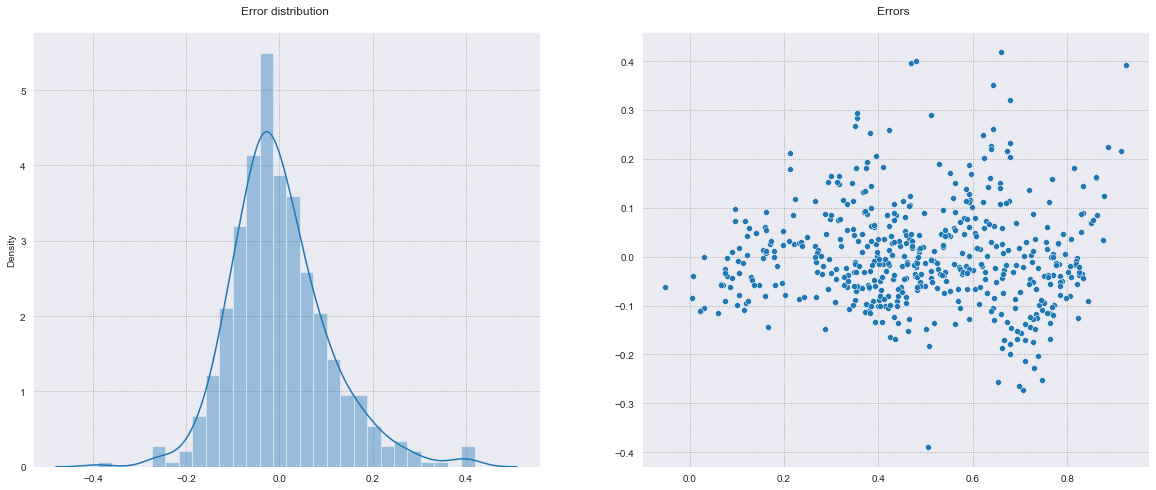

In [166]:
#check if residuals make a nomnial distribution
#AND are centered around 0 
#AND independently distributed

plt.rcParams['figure.figsize']= (20,8)
y_train_pred = lnr_model.predict(X_train_rfe)
res = y_train_pred - y_train
plt.subplot(1,2,1)

sc.distplot(res,norm_hist = False )
plt.title ("Error distribution \n")
plt.subplot(1,2,2)
plt.title ("Errors \n")
sc.scatterplot(x= y_train_pred , y= res)

plt.show()
#INSIGHT:
## normally distributed and randomly spread. 
#perfectly match the criteria for error distribution to suggest model is good representation of population

## Step4: Prediction and Evaluation

In [167]:
#scale the test data
df_test[num_features] = scalar.transform(df_test[num_features])
# take only columns for which the model is trained
X_test = df_test[col_rfe]
y_test = df_test.pop('count')
#add constant
X_test_sm = sm.add_constant(X_test)


In [169]:
# predict
y_pred_test = lnr_model.predict(X_test_sm)

In [173]:
#Evaluate
r2_score(y_true= y_test, y_pred= y_pred_test)

# R2 score of ~.76 for test data in comparison to .80   for training data- (only a slight drop) suggests it to be quite satifactory.

0.7572706567379792

In [174]:
# RELEVANT features impacting significantly on the bike renting business  

list(X_test.columns)

['year', 'atemp', 'humidity', 'windspeed', 'spring']

#### The top five factors contributing to demand of rented bikes are as below:
- feeling temprature (rate  of change/coefficient  ~ +46%)
- humidity (rate  of change/coefficient ~-27%)
- year of renting (rate  of change/coefficient ~ +25% )
- windspeed (rate  of change/coefficient ~ -22%) 
- Spring season (rate  of change/coefficient ~ -17%)

The model strongly suggests that business can expect growth in coming years. The temprature rise causes a positive impact on the demand for bikes.  An increase in  humidity, windspeed & Spring season causes a dip in demand for shared bikes 

The model is able to describe roughly .757 variance of bike demand.